# openPMD beamphysics examples

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Nicer plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Basic Usage

In [2]:
from pmd_beamphysics import ParticleGroup

In [3]:
P = ParticleGroup( 'data/bmad_particles2.h5')
P

<ParticleGroup with 100000 particles at 0x7fe2255b8b20>

In [4]:
P.energy

array([8.00032916e+09, 7.97408124e+09, 7.97338447e+09, ...,
       7.97531701e+09, 7.97163591e+09, 7.97170403e+09])

In [5]:
P['mean_energy'], P.units('mean_energy')

(7974939710.08345, pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0)))

In [6]:
P.where(P.x < P['mean_x'])

<ParticleGroup with 50082 particles at 0x7fe2255b8e80>

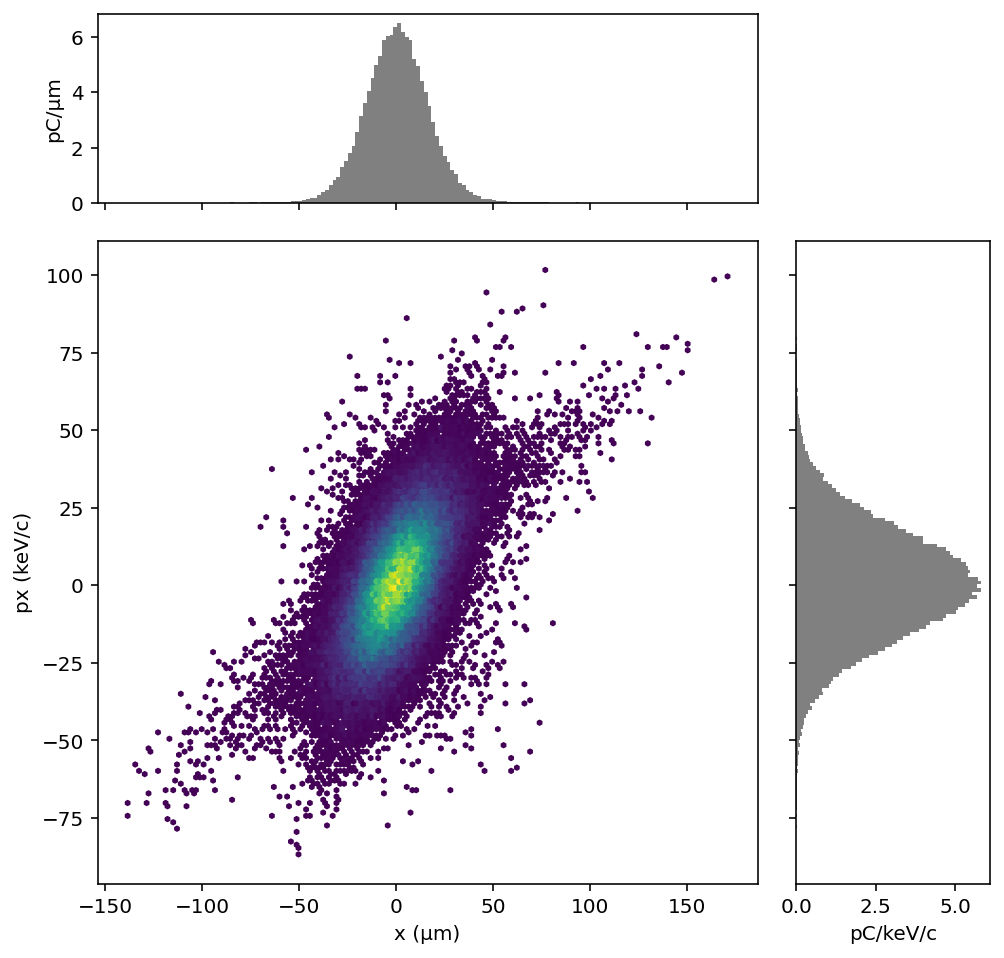

In [7]:
P.plot('x', 'px', figsize=(8,8))

In [8]:
P.write_elegant('elegant_particles.txt', verbose=True)

writing 100000 particles to elegant_particles.txt


# ParticleGroup class

In [9]:
?P

Type:        ParticleGroup
String form: ParticleGroup with 100000 particles with total charge 2.499999999999999e-10 C
Length:      100000
File:        ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/particles.py
Docstring:  
Particle Group class

Initialized on on openPMD beamphysics particle group:
    h5 = open h5 handle, or str that is a file
    data = raw data

The required bunch data is stored in __dict__ with keys
    np.array: x, px, y, py, z, pz, t, status, weight
    str: species
where:
    x, y, z are positions in units of [m]
    px, py, pz are momenta in units of [eV/c]
    t is time in [s]
    weight is the macro-charge weight in [C], used for all statistical calulations.
    species is a proper species name: 'electron', etc. 
    
Optional data:
    np.array: id
where:
    id is a list of unique integers that identify the particles. 

    
Derived data can be computed as attributes:
    .gamma, .beta, .beta_x, .beta_y, .beta_z: relativistic factors [1].
    .r, .theta:

In [10]:
# x positions, in meters
P.x

array([-1.20890504e-05,  2.50055966e-05,  1.84022924e-06, ...,
       -1.87135206e-06,  1.19494768e-06, -1.04551798e-05])

In [11]:
# relativistic gamma, calculated on the fly
P.gamma

array([15656.25362205, 15604.88772858, 15603.52416601, ...,
       15607.30607107, 15600.10233296, 15600.23563914])

In [12]:
# Both are allowed
len(P), P['n_particle']

(100000, 100000)

## Basic Statistics

In [13]:
# Statistics on any of these. Note that these properly use the .weight array. 
P.avg('gamma'), P.std('p')

(15606.56770446094, 7440511.955100455)

In [14]:
# Covariance matrix of any list of keys
P.cov('x', 'px', 'y', 'kinetic_energy')

array([[ 3.05290090e-10,  1.93582323e-01,  2.14462846e-12,
        -3.94841065e+00],
       [ 1.93582323e-01,  3.26525376e+08, -2.44058325e-05,
        -5.36815277e+08],
       [ 2.14462846e-12, -2.44058325e-05,  4.71979014e-10,
        -8.48100957e-01],
       [-3.94841065e+00, -5.36815277e+08, -8.48100957e-01,
         5.53617715e+13]])

In [15]:
# These can all be accessed with brackets. sigma_ and mean_ are also allowed
P['sigma_x'], P['sigma_energy'], P['min_y'], P['norm_emit_x'], P['norm_emit_4d']

(1.7472465109340715e-05,
 7440511.939853717,
 -0.00017677380499644412,
 4.881047612307433e-07,
 2.4484888474798623e-13)

In [16]:
# Covariance has a special syntax, items separated by __
P['cov_x__kinetic_energy']

-3.9484106461190627

In [17]:
# n-dimensional histogram. This is a wrapper for numpy.histogramdd
H, edges = P.histogramdd('t', 'delta_pz', bins=(5,10))
H.shape, edges

((5, 10),
 [array([5.16387938e-06, 5.16387943e-06, 5.16387948e-06, 5.16387953e-06,
         5.16387958e-06, 5.16387963e-06]),
  array([-24476455.61834908, -17729298.92490654, -10982142.231464  ,
          -4234985.53802147,   2512171.15542107,   9259327.8488636 ,
          16006484.54230614,  22753641.23574867,  29500797.92919121,
          36247954.62263375,  42995111.31607628])])

## Advanced statisics

Twiss and Dispersion can be calculated.

These are the projected Twiss parameters. 

TODO: normal mode twiss. 

In [18]:
P.twiss('x')

{'alpha_x': -0.7764646310859605,
 'beta_x': 9.758458404204259,
 'gamma_x': 0.16425722762079686,
 'emit_x': 3.1255806600595395e-11,
 'eta_x': -0.0005687740085942673,
 'etap_x': -9.69649743612097e-06,
 'norm_emit_x': 4.877958608683612e-07}

In [19]:
# 95% calc
P.twiss('x', fraction=0.95)

{'alpha_x': -0.765323995145385,
 'beta_x': 9.233496626510156,
 'gamma_x': 0.1717356795249758,
 'emit_x': 2.3954681527227138e-11,
 'eta_x': -0.0004717155629444416,
 'etap_x': -1.6006449526750024e-05,
 'norm_emit_x': 3.7384085556684757e-07}

In [20]:
# New particles 
P2 = P.twiss_match(beta=30, alpha=-3, plane = 'x')
P2.twiss('x')

{'alpha_x': -2.9996935644621994,
 'beta_x': 29.99130803172276,
 'gamma_x': 0.3333686370097817,
 'emit_x': 3.1255806601163326e-11,
 'eta_x': -0.000997118623912468,
 'etap_x': -7.944656701598246e-05,
 'norm_emit_x': 4.877958608785158e-07}

## Units

In [21]:
# Units can be retrieved from any computable quantitiy.
# These are returned as a pmd_unit type.
P.units('x'), P.units('energy'), P.units('norm_emit_x'), P.units('cov_x__kinetic_energy'), P.units('norm_emit_4d')

(pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0)),
 pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0)),
 pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0)),
 pmd_unit('m*eV', 1.602176634e-19, (3, 1, -2, 0, 0, 0, 0)),
 pmd_unit('(m)^2', 1, (2, 0, 0, 0, 0, 0, 0)))

In [22]:
P.units('mean_energy')

pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0))

In [23]:
# 
str(P.units('cov_x__kinetic_energy'))

'm*eV'

## z vs t

In [24]:
# These particles are from Bmad, at the same z and different times
P.std('z'), P.std('t')

(0.0, 2.4466662184814374e-14)

In [25]:
# Get the central time
t0 = P.avg('t')
t0

5.163879459127423e-06

In [26]:
# Drift all particles to this time
P.drift_to_t(t0)

In [27]:
# Now these are at different z, and the same t
P.std('z'), P.avg('t'), set(P.t)

(7.334920780350132e-06, 5.163879459127425e-06, {5.163879459127423e-06})

## status, weight, id, copy

In [28]:
# Status == 1 is alive, otherwise dead. Set the first ten particles to a different status.
# n_alive, n_dead count these
P.status[0:10] = 0
P.status, P.n_alive, P.n_dead

(array([0, 0, 0, ..., 1, 1, 1], dtype=int32), 99990, 10)

In [29]:
# Convenience routine
P0 = P.where(P.status==0)
P1 = P.where(P.status==1)
len(P0), P0.charge, P1.charge

(10, 2.4999999999999994e-14, 2.4997499999999996e-10)

In [30]:
# Copy is a deep copy
P2 = P1.copy()

In [31]:
# Charge can also be set. This will re-scale the weight array

P2.charge = 9.8765e-12
P1.weight[0:2], P2.weight[0:2], P2.charge


(array([2.5e-15, 2.5e-15]),
 array([9.87748775e-17, 9.87748775e-17]),
 9.876499999999997e-12)

In [32]:
# Some codes provide ids for particles. If not, you can assign an id. 
P.assign_id()
P.id

array([     1,      2,      3, ...,  99998,  99999, 100000])

# Writing

In [33]:
import h5py
import numpy as np

In [34]:

newh5file = 'particles.h5'

with h5py.File(newh5file, 'w') as h5:
    P.write(h5)
    
with h5py.File(newh5file, 'r') as h5:
    P2 = ParticleGroup(h5)    

In [35]:
# Check if all are the same
for key in ['x', 'px', 'y', 'py', 'z', 'pz', 't', 'status', 'weight', 'id']:
    same = np.all(P[key] == P2[key])
    print(key, same)

x True
px True
y True
py True
z True
pz True
t True
status True
weight True
id True


In [36]:
# Write Astra-style particles
P.write_astra('astra.dat')

In [37]:
!head astra.dat

  5.358867254236e-07  -2.266596025469e-08   2.743173452837e-13   5.432293116193e+02   1.634894200076e+01   7.974939693676e+09   5.163879459127e+03   0.000000000000e+00    1   -1
 -1.208904511904e-05   2.743402818288e-05  -5.473095269153e-06  -7.699432808273e+03   1.073320266862e+04   2.538945179648e+07  -1.818989403546e-12   2.500000000000e-06    1   -1
  2.500557812617e-05   1.840484451196e-06  -6.071970122807e-06   2.432464253407e+04  -2.207080331882e+03  -8.584659148073e+05  -1.818989403546e-12   2.500000000000e-06    1   -1
  1.840224855502e-06   2.319774542484e-05  -1.983837488548e-06   1.761897150333e+04  -4.269379756219e+03  -1.555244938371e+06  -1.818989403546e-12   2.500000000000e-06    1   -1
  1.282953228685e-05   2.807375273984e-06   7.759268653990e-06   1.898440718152e+04  -5.303751910566e+03  -2.614389107333e+06  -1.818989403546e-12   2.500000000000e-06    1   -1
  3.362374691900e-06   4.796982704111e-06  -1.006752695161e-06   1.012222041635e+04   1.266876546973e+04  -1.8

In [38]:
# Optionally, a string can be given
P.write('particles.h5')

# Plot

Some plotting is included for convenience. See plot_examples.ipynb for better plotting. 

In [39]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

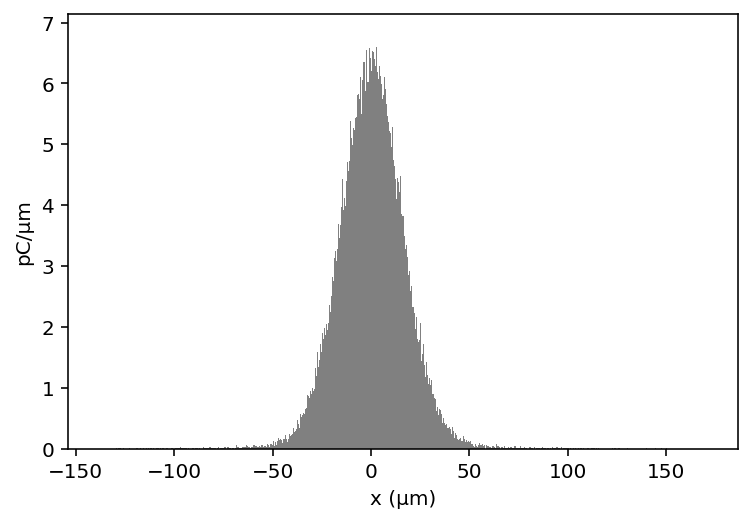

In [40]:
# 1D density plot
P.plot('x')

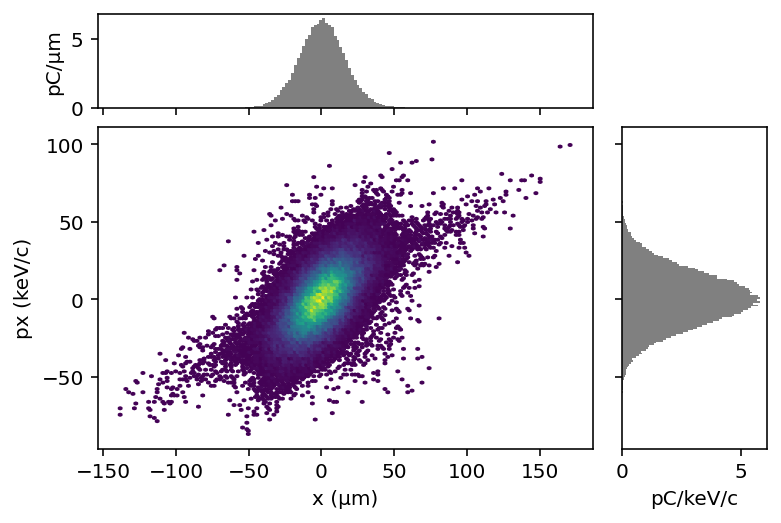

In [41]:
# 2D density plot
P.plot('x', 'px')

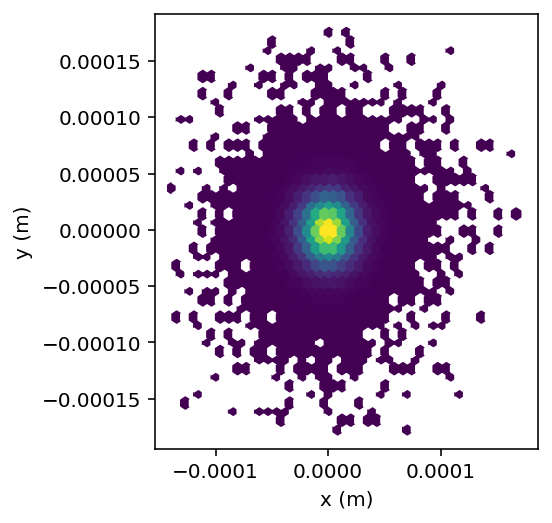

In [42]:
# Manual plotting

import copy


fig, ax = plt.subplots()
ax.set_aspect('equal')
xkey = 'x'
ykey = 'y'
datx = P[xkey]
daty = P[ykey]
ax.set_xlabel(f'{xkey} ({P.units(xkey)})')
ax.set_ylabel(f'{ykey} ({P.units(ykey)})')

cmap = copy.copy(plt.get_cmap('viridis'))
cmap.set_under('white')
ax.hexbin(datx, daty, gridsize=40, cmap=cmap, vmin=1e-15)

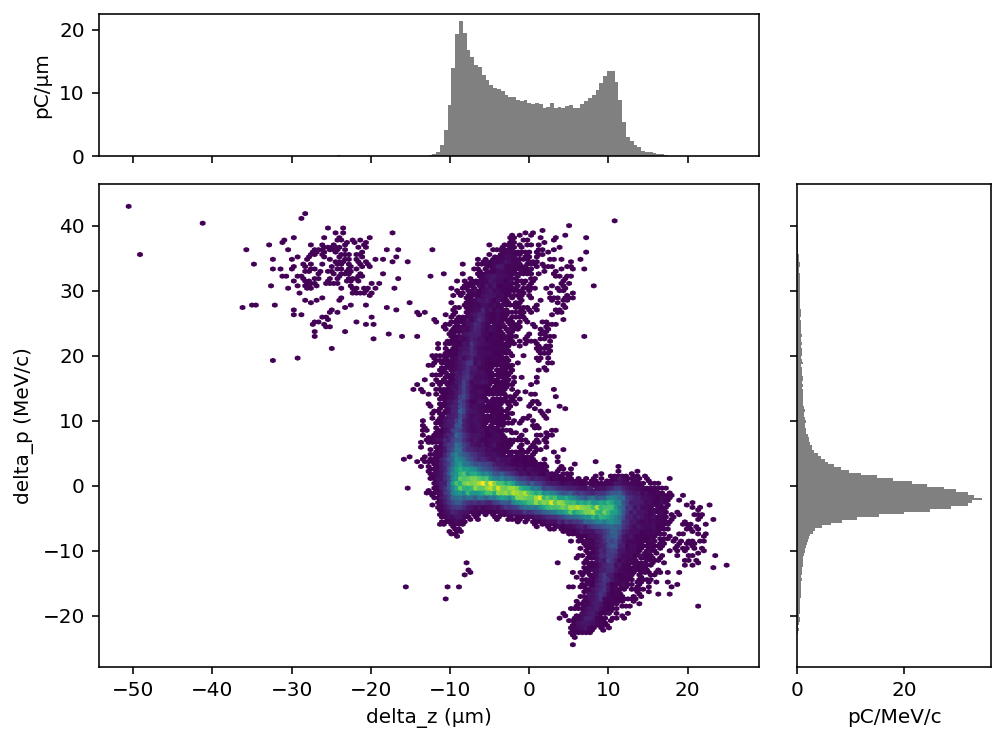

In [43]:
P.plot('delta_z', 'delta_p', figsize=(8,6))

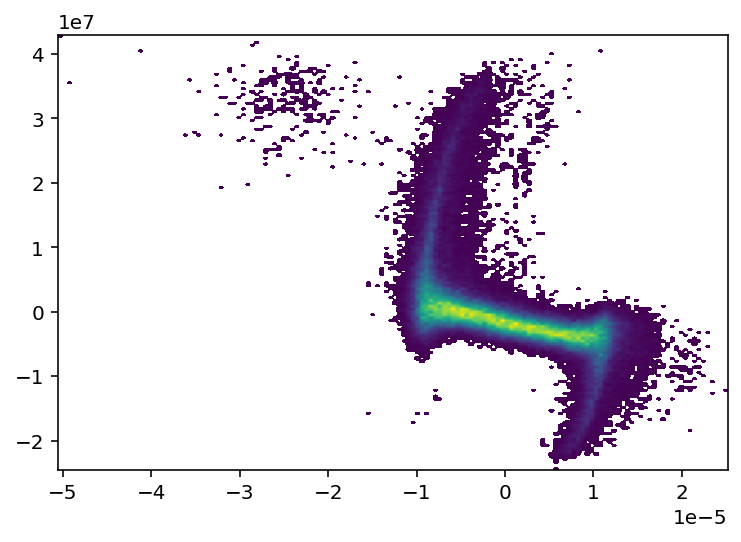

In [44]:
# Manual binning and plotting

H, edges = P.histogramdd('delta_z', 'delta_p', bins=(150, 150))
extent = [edges[0].min(),edges[0].max(),edges[1].min(),edges[1].max() ]

plt.imshow(H.T, origin='lower', extent = extent, aspect='auto', vmin=1e-15, cmap=cmap)

# Multiple ParticleGroup in an HDF5 file

This example has two particlegroups. This also shows how to examine the components, without loading the full data.


In [45]:
from pmd_beamphysics import particle_paths
from pmd_beamphysics.readers import all_components, component_str

H5FILE = 'data/astra_particles.h5'
h5 = h5py.File(H5FILE, 'r')

# Get the valid paths
ppaths = particle_paths(h5)
ppaths

['/screen/0/./', '/screen/1/./']

In [46]:
# Search for all valid components in a single path
ph5 = h5[ppaths[0]]
all_components(ph5 )

['momentum/x',
 'momentum/y',
 'momentum/z',
 'momentumOffset/z',
 'particleStatus',
 'position/x',
 'position/y',
 'position/z',
 'positionOffset/z',
 'time',
 'timeOffset',
 'weight']

In [47]:
# Get some info
for component in all_components(ph5):
    info = component_str(ph5, component)
    print(info)

momentum/x [998 items] is a momentum with units: kg*m/s
momentum/y [998 items] is a momentum with units: kg*m/s
momentum/z [998 items] is a momentum with units: kg*m/s
momentumOffset/z [constant 4.660805218675275e-22 with shape 998] is a momentum with units: kg*m/s
particleStatus [998 items]
position/x [998 items] is a length with units: m
position/y [998 items] is a length with units: m
position/z [998 items] is a length with units: m
positionOffset/z [constant 0.50013 with shape 998] is a length with units: m
time [998 items] is a time with units: s
timeOffset [constant 2.0826e-09 with shape 998] is a time with units: s
weight [998 items] is a charge with units: C


In [48]:
import os

# Cleanup
os.remove('astra.dat')
os.remove(newh5file)
os.remove('elegant_particles.txt')